## Noisy Sine 그래프 예측
- LSTM `Many-to-One` 방식

In [1]:
# module import
from tensorflow.keras.layers import Dense, Input, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

* `createData`
    - 입력 1, 출력 1.
    - 입력, 출력 데이터는 3차원 텐서로 return한다.

* X_data = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10), step=3인 경우의 예시.
```
m = [0 1 2 3 4 5 6] # 시작할 인덱스
step = 윈도우 역할. 몇 기간 설정할 것인지.
x = [(1, 2, 3), (2, 3, 4), (3, 4, 5), (4, 5, 6), (5, 6, 7), (6, 7, 8), (7, 8, 9)]
# batch_X : (7, 3, 1)
batch_X = array([[[1],
        [2],
        [3]],

       [[2],
        [3],
        [4]],

       [[3],
        [4],
        [5]],

       [[4],
        [5],
        [6]],

       [[5],
        [6],
        [7]],

       [[6],
        [7],
        [8]],

       [[7],
        [8],
        [9]]])
m이 numpy array니까 +1 하면 각 원소 +1씩 된다.
j를 가지고 하나씩 뒤에까지 구해서 x 다음에 나와야 할 라벨을 구한다.
```



강사님 코드 수정: 굳이 x, y ,따로 해야 할 필요가 없는듯하다.

In [2]:
# 1차원 배열의 시계열 데이터로 학습용 배치 파일 생성
def createData(X_data, step):
    '''
    <params>
        X_data: 생성할 시계열 데이터
        step: 시계열
    <return>
        batch_X : RNN 입력 데이터
        batch_Y : RNN 출력 데이터
    '''

    m = np.arange(len(X_data) - step) # step 전까지. 기본 배열

    x, y = [], []

    for i in m:
        # 입력데이터 생성
        a = X_data[i:(i+step)] # step 옮겨 가며 window처럼 생성
        x.append(a)
        # 라벨데이터 생성
        b = X_data[i+1:(i+1+step)]
        y.append(b[-1])
        
    batch_X = np.reshape(np.array(x), (len(m), step, 1)) # D0: 데이터 개수, D1: step, feature: 1.
    batch_y = np.reshape(np.array(y), (len(m), 1)) # 각각의 2차원 데이터에 대해 라벨이 하나씩 붙으므로, D0 축은 데이터의 개수, D1축은 라벨 개수니까 1.

    return batch_X, batch_y

원래 sine 곡선: np.sin(2 * np.pi * 0.03 * np.arange(1001))

In [3]:
# 시계열 데이터(noise 포함해서 생성)
data = np.arange(1001)*0.01 + np.sin(2 * np.pi * 0.03 * np.arange(1001)) + np.random.random(1001)

In [4]:
# parameters
n_input = 1 # feature 개수
n_output = 1 # 라벨 몇 개인지
n_step = int(input('분석할 step(기간) 수를 설정하세요: '))
n_hidden = int(input('hidden node 뉴런 수를 설정하세요: '))

EPOCHS = int(input('학습 횟수를 설정하세요: '))
BATCH = int(input('배치 사이즈를 설정하세요: '))

분석할 step(기간) 수를 설정하세요: 20
hidden node 뉴런 수를 설정하세요: 50
학습 횟수를 설정하세요: 100
배치 사이즈를 설정하세요: 100


In [5]:
# 시계열 데이터 생성
x, y = createData(data, n_step)
print(f"X 데이터: {x.shape}, y 데이터: {y.shape}")

X 데이터: (981, 20, 1), y 데이터: (981, 1)


In [6]:
print(x[0], y[0]) # 0번째 데이터: 각 20기간이 담겨 있고, 이 때 예측값은 
print(x[980], y[980])

[[0.72964496]
 [0.49782398]
 [0.9577234 ]
 [1.39039079]
 [1.30723367]
 [1.12148906]
 [1.03888043]
 [1.45742838]
 [1.10145755]
 [1.67298889]
 [1.90270837]
 [1.65190702]
 [1.13476454]
 [1.47911326]
 [1.52883524]
 [0.78104294]
 [0.96430039]
 [0.4284071 ]
 [0.08553347]
 [0.4056696 ]] [-0.102587]
[[10.74407208]
 [10.56170175]
 [10.89850103]
 [10.76632535]
 [10.47590437]
 [10.36548002]
 [10.07904619]
 [ 9.90324359]
 [ 9.58433099]
 [ 9.62133737]
 [ 9.40847772]
 [ 9.13924125]
 [ 9.20724198]
 [ 9.0136407 ]
 [ 9.97867339]
 [10.08048213]
 [10.14861471]
 [10.05117986]
 [ 9.76934714]
 [10.23248581]] [10.86880816]


In [7]:
# LSTM 모델 생성
x_Input = Input(batch_shape=(None, n_step, 1)) # 몇 개 있는지 모르므로 None
x_Lstm = LSTM(n_hidden)(x_Input) # LSTM 뉴런에서 히든으로 나가는 뉴런 수는 50
x_Output = Dense(n_output)(x_Lstm) # LSTM 뉴런에서 나와서 출력되어야 하는 수는 1.
model = Model(x_Input, x_Output)
model.compile(loss='mse',
              optimizer=Adam(lr=0.01)) # 회귀 문제이므로
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
# 학습: 학습 시에는 shuffle해도 상관 없음.
hist = model.fit(x, y, epochs=EPOCHS, batch_size=BATCH, shuffle=True)

Epoch 1/100
10/10 [==============================] - 0s 14ms/step - loss: 11.3626
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7155
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2457
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1711
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1745
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1730
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1569
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1577
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1660
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1502
Epoch 11/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1407
Epoch 12/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1461
Epoch 13/100
10/10 [====

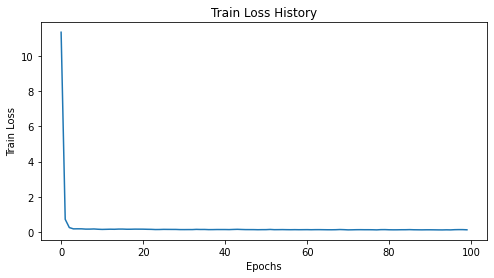

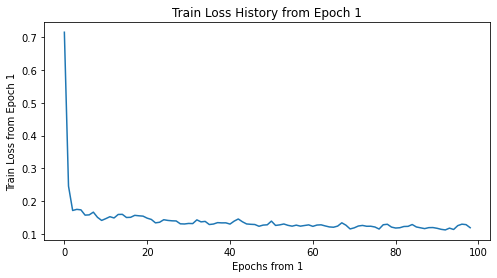

In [9]:
# plot history
plt.figure(figsize=(8, 4))
plt.plot(hist.history['loss'])
plt.title('Train Loss History')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(hist.history['loss'][1:])
plt.title('Train Loss History from Epoch 1')
plt.xlabel('Epochs from 1')
plt.ylabel('Train Loss from Epoch 1')
plt.show()

In [10]:
# 예측
n_future = int(input('예측할 미래 기간 수를 설정하세요: '))

예측할 미래 기간 수를 설정하세요: 20


In [11]:
# 데이터 개수가 너무 많으니까 마지막 100일만 가져온다.
if len(data) > 100:
    last_data = np.copy(data[-100:])
else:
    last_data = np.copy(data)

In [12]:
# 예측에 사용할 마지막 데이터: 원래 data는 사인 곡선 생성하려고 만든 x 좌표들.
X_pred = np.copy(last_data)

# 예측한 애들 저장할 배열
estimate = [X_pred[-1]] # 예측 처음에 마지막 1일부터 시작하게 초기화.

```
0번째 시퀀스: [[[10.63212101]
  [10.60856744]
  [10.7998853 ]
  [10.55473486]
  [ 9.89698368]
  [ 9.51331506]
  [ 9.49289537]
  [ 9.96142479]
  [ 9.60326334]
  [ 9.87334534]
  [ 9.11980084]
  [ 9.84464069]
  [ 9.91556959]
  [ 9.0355223 ]
  [ 9.52879011]
  [ 9.52070787]
  [ 9.46356759]
  [10.33896153]
  [10.09133776]
  [10.78530712]]]
변경된 예측 대상: [ 9.31704819  9.56453436  9.5743764  10.33628295 10.08449268 10.31933123
 10.04040288 10.77281635 11.00917304 10.38107644 10.84419072 10.25678533
 10.02386371  9.95991897 10.36784604 10.17146452  9.2832402   9.5355864
  9.43101853  8.88809886  8.6002459   8.44638025  8.62253548  8.39533549
  8.78465399  8.8798512   8.75182326  9.41648183  9.4727854   9.25645055
  9.21354707  9.58242738  9.71790916  9.82210778  9.75905245 10.18593728
 10.68771351 10.81248152 11.02150394 11.03419569 10.95923655 10.76780495
 11.30808367 10.66592627 10.93845809 10.88163015 10.02112148 10.06652436
  9.96312828 10.46204774  9.87983741  9.53709939  8.99654731  9.61635805
  9.65744765  9.12863998  9.04957234  9.13216996  9.54411375  9.27105242
  9.61931613  9.39942633  9.57047072  9.55941848 10.33091338 10.50467655
 10.45530096 10.69248923 10.73375909 10.42865765 10.90518196 11.22500734
 11.17374712 11.11512221 11.62103433 11.49067535 10.93772801 11.30720153
 11.23750142 10.79576332 10.63212101 10.60856744 10.7998853  10.55473486
  9.89698368  9.51331506  9.49289537  9.96142479  9.60326334  9.87334534
  9.11980084  9.84464069  9.91556959  9.0355223   9.52879011  9.52070787
  9.46356759 10.33896153 10.09133776 10.78530712 10.50329304]
6번째 시퀀스: [[[ 9.49289537]
  [ 9.96142479]
  [ 9.60326334]
  [ 9.87334534]
  [ 9.11980084]
  [ 9.84464069]
  [ 9.91556959]
  [ 9.0355223 ]
  [ 9.52879011]
  [ 9.52070787]
  [ 9.46356759]
  [10.33896153]
  [10.09133776]
  [10.78530712]
  [10.50329304]
  [10.65279293]
  [10.79310513]
  [10.90784073]
  [11.0141449 ]
  [11.12168026]]]
변경된 예측 대상: [ 9.31704819  9.56453436  9.5743764  10.33628295 10.08449268 10.31933123
 10.04040288 10.77281635 11.00917304 10.38107644 10.84419072 10.25678533
 10.02386371  9.95991897 10.36784604 10.17146452  9.2832402   9.5355864
  9.43101853  8.88809886  8.6002459   8.44638025  8.62253548  8.39533549
  8.78465399  8.8798512   8.75182326  9.41648183  9.4727854   9.25645055
  9.21354707  9.58242738  9.71790916  9.82210778  9.75905245 10.18593728
 10.68771351 10.81248152 11.02150394 11.03419569 10.95923655 10.76780495
 11.30808367 10.66592627 10.93845809 10.88163015 10.02112148 10.06652436
  9.96312828 10.46204774  9.87983741  9.53709939  8.99654731  9.61635805
  9.65744765  9.12863998  9.04957234  9.13216996  9.54411375  9.27105242
  9.61931613  9.39942633  9.57047072  9.55941848 10.33091338 10.50467655
 10.45530096 10.69248923 10.73375909 10.42865765 10.90518196 11.22500734
 11.17374712 11.11512221 11.62103433 11.49067535 10.93772801 11.30720153
 11.23750142 10.79576332 10.63212101 10.60856744 10.7998853  10.55473486
  9.89698368  9.51331506  9.49289537  9.96142479  9.60326334  9.87334534
  9.11980084  9.84464069  9.91556959  9.0355223   9.52879011  9.52070787
  9.46356759 10.33896153 10.09133776 10.78530712 10.50329304 10.65279293
 10.79310513 10.90784073 11.0141449  11.12168026 11.20759296]
10번째 시퀀스: [[[ 9.11980084]
  [ 9.84464069]
  [ 9.91556959]
  [ 9.0355223 ]
  [ 9.52879011]
  [ 9.52070787]
  [ 9.46356759]
  [10.33896153]
  [10.09133776]
  [10.78530712]
  [10.50329304]
  [10.65279293]
  [10.79310513]
  [10.90784073]
  [11.0141449 ]
  [11.12168026]
  [11.20759296]
  [11.25418091]
  [11.25606728]
  [11.2289238 ]]]
변경된 예측 대상: [ 9.31704819  9.56453436  9.5743764  10.33628295 10.08449268 10.31933123
 10.04040288 10.77281635 11.00917304 10.38107644 10.84419072 10.25678533
 10.02386371  9.95991897 10.36784604 10.17146452  9.2832402   9.5355864
  9.43101853  8.88809886  8.6002459   8.44638025  8.62253548  8.39533549
  8.78465399  8.8798512   8.75182326  9.41648183  9.4727854   9.25645055
  9.21354707  9.58242738  9.71790916  9.82210778  9.75905245 10.18593728
 10.68771351 10.81248152 11.02150394 11.03419569 10.95923655 10.76780495
 11.30808367 10.66592627 10.93845809 10.88163015 10.02112148 10.06652436
  9.96312828 10.46204774  9.87983741  9.53709939  8.99654731  9.61635805
  9.65744765  9.12863998  9.04957234  9.13216996  9.54411375  9.27105242
  9.61931613  9.39942633  9.57047072  9.55941848 10.33091338 10.50467655
 10.45530096 10.69248923 10.73375909 10.42865765 10.90518196 11.22500734
 11.17374712 11.11512221 11.62103433 11.49067535 10.93772801 11.30720153
 11.23750142 10.79576332 10.63212101 10.60856744 10.7998853  10.55473486
  9.89698368  9.51331506  9.49289537  9.96142479  9.60326334  9.87334534
  9.11980084  9.84464069  9.91556959  9.0355223   9.52879011  9.52070787
  9.46356759 10.33896153 10.09133776 10.78530712 10.50329304 10.65279293
 10.79310513 10.90784073 11.0141449  11.12168026 11.20759296 11.25418091
 11.25606728 11.2289238  11.1738081 ]
15번째 시퀀스: [[[ 9.52070787]
  [ 9.46356759]
  [10.33896153]
  [10.09133776]
  [10.78530712]
  [10.50329304]
  [10.65279293]
  [10.79310513]
  [10.90784073]
  [11.0141449 ]
  [11.12168026]
  [11.20759296]
  [11.25418091]
  [11.25606728]
  [11.2289238 ]
  [11.1738081 ]
  [11.07597446]
  [10.9406147 ]
  [10.83065128]
  [10.73289776]]]
변경된 예측 대상: [ 9.31704819  9.56453436  9.5743764  10.33628295 10.08449268 10.31933123
 10.04040288 10.77281635 11.00917304 10.38107644 10.84419072 10.25678533
 10.02386371  9.95991897 10.36784604 10.17146452  9.2832402   9.5355864
  9.43101853  8.88809886  8.6002459   8.44638025  8.62253548  8.39533549
  8.78465399  8.8798512   8.75182326  9.41648183  9.4727854   9.25645055
  9.21354707  9.58242738  9.71790916  9.82210778  9.75905245 10.18593728
 10.68771351 10.81248152 11.02150394 11.03419569 10.95923655 10.76780495
 11.30808367 10.66592627 10.93845809 10.88163015 10.02112148 10.06652436
  9.96312828 10.46204774  9.87983741  9.53709939  8.99654731  9.61635805
  9.65744765  9.12863998  9.04957234  9.13216996  9.54411375  9.27105242
  9.61931613  9.39942633  9.57047072  9.55941848 10.33091338 10.50467655
 10.45530096 10.69248923 10.73375909 10.42865765 10.90518196 11.22500734
 11.17374712 11.11512221 11.62103433 11.49067535 10.93772801 11.30720153
 11.23750142 10.79576332 10.63212101 10.60856744 10.7998853  10.55473486
  9.89698368  9.51331506  9.49289537  9.96142479  9.60326334  9.87334534
  9.11980084  9.84464069  9.91556959  9.0355223   9.52879011  9.52070787
  9.46356759 10.33896153 10.09133776 10.78530712 10.50329304 10.65279293
 10.79310513 10.90784073 11.0141449  11.12168026 11.20759296 11.25418091
 11.25606728 11.2289238  11.1738081  11.07597446 10.9406147  10.83065128
 10.73289776 10.63375187]
19번째 시퀀스: [[[10.78530712]
  [10.50329304]
  [10.65279293]
  [10.79310513]
  [10.90784073]
  [11.0141449 ]
  [11.12168026]
  [11.20759296]
  [11.25418091]
  [11.25606728]
  [11.2289238 ]
  [11.1738081 ]
  [11.07597446]
  [10.9406147 ]
  [10.83065128]
  [10.73289776]
  [10.63375187]
  [10.52024174]
  [10.39453506]
  [10.26683331]]]
변경된 예측 대상: [ 9.31704819  9.56453436  9.5743764  10.33628295 10.08449268 10.31933123
 10.04040288 10.77281635 11.00917304 10.38107644 10.84419072 10.25678533
 10.02386371  9.95991897 10.36784604 10.17146452  9.2832402   9.5355864
  9.43101853  8.88809886  8.6002459   8.44638025  8.62253548  8.39533549
  8.78465399  8.8798512   8.75182326  9.41648183  9.4727854   9.25645055
  9.21354707  9.58242738  9.71790916  9.82210778  9.75905245 10.18593728
 10.68771351 10.81248152 11.02150394 11.03419569 10.95923655 10.76780495
 11.30808367 10.66592627 10.93845809 10.88163015 10.02112148 10.06652436
  9.96312828 10.46204774  9.87983741  9.53709939  8.99654731  9.61635805
  9.65744765  9.12863998  9.04957234  9.13216996  9.54411375  9.27105242
  9.61931613  9.39942633  9.57047072  9.55941848 10.33091338 10.50467655
 10.45530096 10.69248923 10.73375909 10.42865765 10.90518196 11.22500734
 11.17374712 11.11512221 11.62103433 11.49067535 10.93772801 11.30720153
 11.23750142 10.79576332 10.63212101 10.60856744 10.7998853  10.55473486
  9.89698368  9.51331506  9.49289537  9.96142479  9.60326334  9.87334534
  9.11980084  9.84464069  9.91556959  9.0355223   9.52879011  9.52070787
  9.46356759 10.33896153 10.09133776 10.78530712 10.50329304 10.65279293
 10.79310513 10.90784073 11.0141449  11.12168026 11.20759296 11.25418091
 11.25606728 11.2289238  11.1738081  11.07597446 10.9406147  10.83065128
 10.73289776 10.63375187 10.52024174 10.39453506 10.26683331 10.15812778]
 ```

In [13]:
# 계속 반복할 것: 이거 함수로 만들어도 되지 않을까
for _ in range(n_future):
    x = X_pred[-n_step:].reshape(1, n_step, 1) # 마지막 시퀀스 데이터 가져 와서 LSTM 모델 형태로 만든다. d0: 데이터 1개, n_step 시퀀스 길이, feature1
    y_hat = model.predict(x)[0][0] # y_hat은 [[10.503293]] : LSTM 모델에 넣은 형태 다시 생각해 보면 1차원 라벨 d0축 개수만큼 있어야 하는데 라벨 1개만 나왔으니까 저렇게 껍데기 두개다.
    estimate.append(y_hat) # 추정값 저장
    X_pred = np.insert(X_pred, len(X_pred), y_hat) # 마지막 위치 인덱스(len(X_pred))에 추정값 추가해서 늘림: 인덱스 0부터 시작하니까 len(X_pred)자리는 원래 없던 애.

In [14]:
estimate

[10.86880816155736,
 10.60765,
 10.714847,
 10.784239,
 10.834631,
 10.862201,
 10.864786,
 10.840796,
 10.797013,
 10.738267,
 10.670045,
 10.611567,
 10.549443,
 10.487655,
 10.414124,
 10.3236,
 10.237113,
 10.154091,
 10.0796175,
 10.015583,
 9.954574]

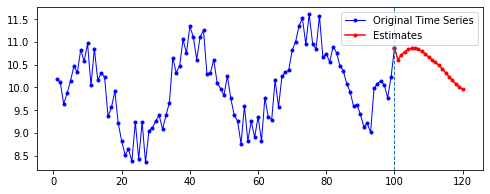

In [15]:
# 원 데이터와 예측된 시계열을 그려 보자
ax1 = np.arange(1, len(last_data)+1) # 원래 데이터
ax2 = np.arange(len(last_data), len(last_data) + len(estimate)) # 추정치까지 합한

plt.figure(figsize=(8, 3))
plt.plot(ax1, last_data, 'b-o', color='blue', markersize=3, label='Original Time Series', linewidth=1)
plt.plot(ax2, estimate, 'b-o', color='red', markersize=3, label='Estimates')
plt.axvline(x=ax1[-1], linestyle='dashed', linewidth=1) ## 수직선 그어 준다.
plt.legend()
plt.show()

# 사인곡선

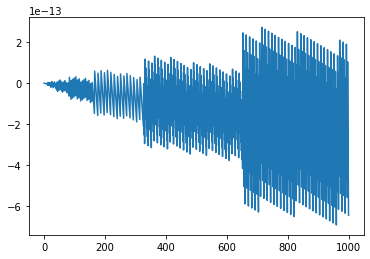

In [37]:
plt.plot(np.sin(2 * np.pi * np.arange(1001)))

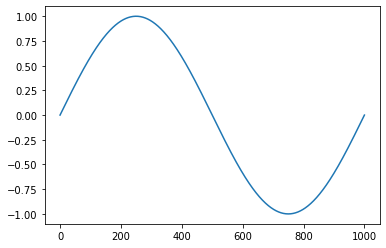

In [38]:
plt.plot(np.sin(2 * np.pi * 0.001 * np.arange(1001)))

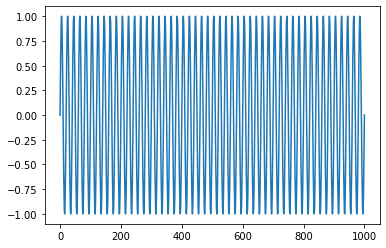

In [35]:
plt.plot(np.sin(2 * np.pi * 0.05 * np.arange(1001)))

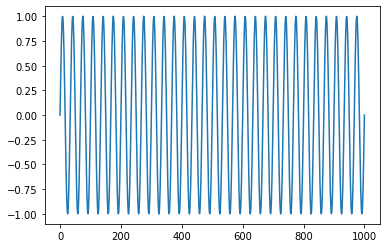

In [26]:
plt.plot(np.sin(2 * np.pi * 0.03 * np.arange(1001)))

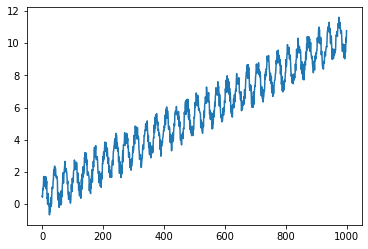

In [24]:
plt.plot(data)

# 강사님 함수 수정

In [3]:
def createTrainData(xData, step):
    m = np.arange(len(xData) - step)
    
    x, y = [], []
    for i in m:
        a = xData[i:(i+step)]
        x.append(a)
    xBatch = np.reshape(np.array(x), (len(m), step, 1))
    
    for i in m+1:
        a = xData[i:(i+step)]
        y.append(a[-1])
    yBatch = np.reshape(np.array(y), (len(m), 1))
    
    return xBatch, yBatch

In [4]:
x_1, y_1 = createData((1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 3) # 내 방식
x_2, y_2 = createTrainData((1, 2, 3, 4, 5, 6, 7, 8, 9, 10), 3) # 강사님 방식

In [5]:
print(x_1)
print(x_2)
print(x_1 == x_2)

[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]

 [[6]
  [7]
  [8]]

 [[7]
  [8]
  [9]]]
[[[1]
  [2]
  [3]]

 [[2]
  [3]
  [4]]

 [[3]
  [4]
  [5]]

 [[4]
  [5]
  [6]]

 [[5]
  [6]
  [7]]

 [[6]
  [7]
  [8]]

 [[7]
  [8]
  [9]]]
[[[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]]]


In [6]:
print(y_1)
print(y_2)
print(y_1 == y_2)

[[ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]]
[[ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]
 [ True]]
